In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import zipfile
import random
import pathlib
import IPython.display as display

UsageError: Line magic function `%tensorflow_version` not found.


解压dataset

In [ ]:
data_path = '/content/drive/My Drive/2_class.zip'
fz = zipfile.ZipFile(data_path, 'r')
fz.extractall()

读取文件路径 并存储文件个数、文件名称

In [ ]:
file_path = '/content/drive/My Drive/2_class'
def get_all_path(open_file_path):
    rootdir = open_file_path
    path_list = []
    list = os.listdir(rootdir)  # 列出文件夹下所有的目录与文件
    for i in range(0, len(list)):
        com_path = os.path.join(rootdir, list[i])
        #print(com_path)
        if os.path.isfile(com_path):
            path_list.append(com_path)
        if os.path.isdir(com_path):
            path_list.extend(get_all_path(com_path))
    return path_list
# 所有的文件路径
all_image_list = get_all_path(file_path)
random.shuffle(all_image_list)
# 文件个数
img_count = len(all_image_list)
# 类别名称
label_names = os.listdir(file_path)
# 名称转成数字
label_to_index = dict((name, index) for index, name in enumerate(label_names))
# 取得所有文件的label
all_image_label = [label_to_index[pathlib.Path(p).parent.name] for p in all_image_list]


IPython.display显示图片

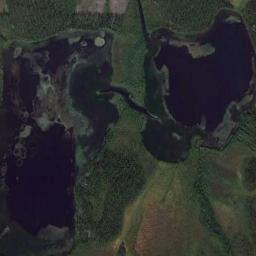

In [52]:
display.display(display.Image(all_image_list[0]))

tensorflow读取图片流程
* tf.io.read_file读取图片
* tf.io.decode_image解码图片
* tf.cast转换数据图片数据类型
* 图片数据归一化


In [ ]:
def load_preprocess_img(path):
  img_raw = tf.io.read_file(path)
  img_tensor = tf.io.decode_jpeg(img_raw, channels=3)
  img_tensor = tf.image.resize(img_tensor, [256, 256])
  img_tensor = tf.dtypes.cast(img_tensor, tf.float32)
  img = img_tensor/255
  return img

讲图片数据管道化（Dataset）

In [ ]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_list)
image_dataset = path_ds.map(load_preprocess_img)
label_dataset = tf.data.Dataset.from_tensor_slices(all_image_label)

In [ ]:
dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

划分测试机和训练集

In [171]:
test_count = int(img_count*0.2)
train_count = img_count - test_count
train_imgdataset = dataset.skip(test_count)
test_imgdataset = dataset.take(test_count)

BATCH_SIZE = 32
ds_train = train_imgdataset.shuffle(buffer_size=train_count).batch(BATCH_SIZE).repeat()
ds_test = test_imgdataset.batch(BATCH_SIZE)
ds_train

<RepeatDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

建立模型

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation="relu"))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(128, (3,3), activation="relu"))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(256, (3,3), activation="relu"))
model.add(tf.keras.layers.Conv2D(256, (3,3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3,3), activation="relu"))
model.add(tf.keras.layers.Conv2D(512, (3,3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(1024, (3,3), activation="relu"))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    metrics=["acc"],
    optimizer="adam"
)

In [ ]:
steps_per_epoch = train_count//BATCH_SIZE
validation_steps = test_count//BATCH_SIZE

In [172]:
history = model.fit(
    ds_train, 
    epochs=30, 
    steps_per_epoch=steps_per_epoch, 
    validation_data=ds_test, 
    validation_steps=validation_steps
)

Train for 35 steps, validate for 8 steps
Epoch 1/30
35/35 [==============================] - 11s 316ms/step - loss: 0.1922 - acc: 0.9500 - val_loss: 0.2057 - val_acc: 0.9570
Epoch 2/30
35/35 [==============================] - 10s 289ms/step - loss: 0.1553 - acc: 0.9607 - val_loss: 0.1304 - val_acc: 0.9570
Epoch 3/30
35/35 [==============================] - 10s 292ms/step - loss: 0.1281 - acc: 0.9607 - val_loss: 0.1031 - val_acc: 0.9609
Epoch 4/30
35/35 [==============================] - 10s 298ms/step - loss: 0.1415 - acc: 0.9580 - val_loss: 0.2344 - val_acc: 0.9297
Epoch 5/30
35/35 [==============================] - 10s 290ms/step - loss: 0.1146 - acc: 0.9625 - val_loss: 0.1050 - val_acc: 0.9648
Epoch 6/30
35/35 [==============================] - 10s 288ms/step - loss: 0.0965 - acc: 0.9679 - val_loss: 0.0922 - val_acc: 0.9609
Epoch 7/30
35/35 [==============================] - 10s 289ms/step - loss: 0.1488 - acc: 0.9723 - val_loss: 0.2075 - val_acc: 0.9375
Epoch 8/30
35/35 [==========

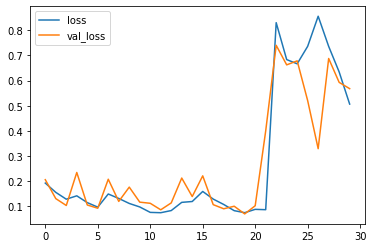

In [173]:
plt.plot(history.epoch, history.history.get("loss"), label="loss")
plt.plot(history.epoch, history.history.get("val_loss"), label="val_loss")
plt.legend()